αandβare fixed in this period. The valueT(−14)corresponds to the con-firmed cases on March 2nd andT(−15) = 0. At this point, we evaluate thevectorθ0= (α,β,E(−14),I(−14),A(−14))that minimizes the expression0∑i=−14wi(y(1)i−ˆT(i,θ0))2,where the weightswi=i+ 1414are chosen to give less importance to the147initial days. With these estimates, we obtain the values(E(0),I(0),A(0)).148SinceR(−14) = 0, we get thatQ(−14) =T(−14), and thus we can integrate149the curvesQandRto obtain the valuesQ(0)andR(0). Finally, we deduce150S(0) = 1−E(0)−I(0)−A(0)−Q(0)−R(0). What about the values ofα151andβinθ0# Análise dos dados de COVID-19 da cidade do Rio de Janeiro

A partir do [site do município do Rio de Janeiro](https://www.data.rio/datasets/f314453b3a55434ea8c8e8caaa2d8db5), é obtemos dados de cada indivíduo que teve confirmação da presença da doença COVID-19 na cidade. Eles estão também disponíveis em formato de [Painel](https://experience.arcgis.com/experience/38efc69787a346959c931568bd9e2cc4), com atualização diária e podem ser baixados em formato CSV. 

Campos disponíveis:
---

`classificacao_final:` mostra a classificação dos casos. Casos confirmados são marcados como "CONFIRMADOS".

`dt_notific:` data em que foi feita a notificação do caso, em formato mm/dd/aa.

`dt_inicio_sintomas:` data relatada do início dos sintomas, em formato mm/dd/aa.

`bairro_resid_estadia:` bairro de residência ou estadia do paciente usando a lista oficial de bairros do município do Rio de Janeiro.

`ap_residencia_estadia:` Área de Planejamento em Saúde correspondente ao bairro de residência ou estadia do paciente.

`sexo:` sexo do paciente, podendo ser M= masculino; F= feminino; ou N/D= sem informação.

`faixa_etaria:` faixa etária em que se encontra o paciente.

`evolucao:` evolução do caso, podendo ser ativo, óbito ou recuperado.

`dt_evolucao:` data em que ocorreu a evolução do quadro, podendo ser a data de óbito ou a data de alta/cura, em formato mm/dd/aa.

`raca_cor:` raça/cor do paciente.

`Data_atualizacao:` data a que se referem os dados, em formato mm/dd/aa.

`sistema:` sistema de origem do registro, podendo ser e-SUS para os casos leves e SIVEP-Gripe para os casos de internação e óbitos.

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Obtenção dos dados através do documento CSV. Poderíamos obter isso de forma online, mas não é interessante dado que os dados variam muito no momento da modelagem. Se você quiser atualizar, basta apagar os dados antigos e colocar um nome com a estrutura `oficial_rio_[data_download]`. 

In [2]:
for f in os.listdir('../data'):
    if f[0:11] == 'oficial_rio':
        filename = f

In [3]:
covid_data_raw = pd.read_csv('../data/' + filename, sep = ';')
covid_data_raw.columns

Index(['classificação_final', 'dt_notific', 'dt_inicio_sintomas',
       'bairro_resid_estadia', 'ap_residencia_estadia', 'sexo', 'faixa_etaria',
       'evolucao', 'dt_evolucao', 'raca_cor', 'Data_atualizacao', 'sistema'],
      dtype='object')

As variáveis "classificação total", "sistema" e "Data_atualizacao" não são interessantes, pois a primeira só possui a variável "Confirmado", enquanto a segunda só tem os nomes "SIVED" ou "ESUS", que não são de interesse. Já a informação da terceira está embutida no nome do arquivo.  

In [4]:
covid_data = covid_data_raw.drop(columns = ['classificação_final', 'sistema', 'Data_atualizacao'])

In [5]:
covid_data.head()

,dt_notific,dt_inicio_sintomas,bairro_resid_estadia,ap_residencia_estadia,sexo,faixa_etaria,evolucao,dt_evolucao,raca_cor
0,09/18/20,09/03/20,PACIENCIA,5.3,M,De 50 a 59,OBITO,09/17/20,Preta
1,11/25/20,11/02/20,BARRA DA TIJUCA,4.0,M,De 80 a 89,OBITO,12/01/20,Branca
2,05/06/20,05/06/20,CACHAMBI,3.2,M,De 70 a 79,OBITO,05/07/20,Ignorado
3,11/12/20,11/02/20,BARRA DA TIJUCA,4.0,M,De 70 a 79,OBITO,12/12/20,Branca
4,06/13/20,04/26/20,MARECHAL HERMES,3.3,M,De 60 a 69,OBITO,05/16/20,Ignorado


Aqui podemos conferir que existem colunas com missinng values. Em particular a coluna `dt_evolucao` tem mais de 10 mil valores faltantes. Isso pode ser prejudicial, pois não temos a informação exata de quanto uma pessoa evolui para um óbito ou recuperação. Vamos analisar mais de perto em seguida. 

In [6]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188999 entries, 0 to 188998
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   dt_notific             188964 non-null  object
 1   dt_inicio_sintomas     188887 non-null  object
 2   bairro_resid_estadia   188999 non-null  object
 3   ap_residencia_estadia  188999 non-null  object
 4   sexo                   188999 non-null  object
 5   faixa_etaria           188999 non-null  object
 6   evolucao               188999 non-null  object
 7   dt_evolucao            177815 non-null  object
 8   raca_cor               188999 non-null  object
dtypes: object(9)
memory usage: 13.0+ MB


As linhas sem data de notificação serão excluídas, porque sem elas não temos muita informação adicional à dinâmica do modelo. Vamos transformar todas as variáveis de tempo em `datetime`. 

In [7]:
covid_data.dropna(subset = ['dt_notific'], inplace = True)

In [8]:
time_variables = ['dt_notific', 'dt_inicio_sintomas', 'dt_evolucao'] 
covid_data[time_variables] = covid_data[time_variables].apply(pd.to_datetime)

## Casos notificados e início dos sintomas

Podemos contar o número de indivíduos infectados a cada dia e apresentar em um gráfico. Além disso, podemos calcular a média de 7 dias, a fim de reduzir a variabilidade semanal. 

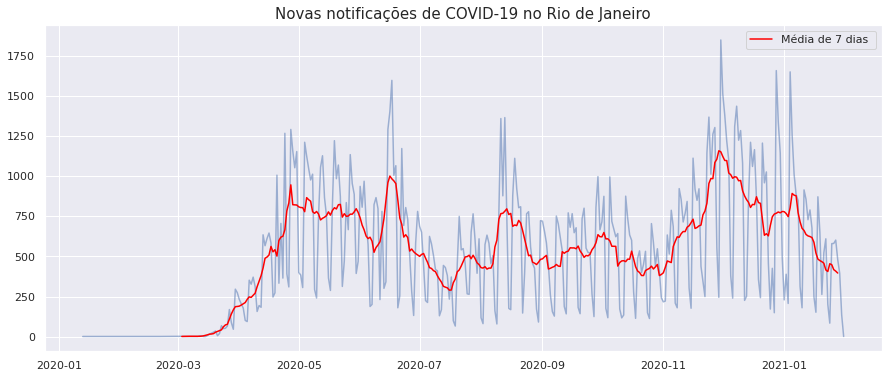

In [9]:
notified_cases = covid_data.dt_notific.value_counts().sort_index()
sevendays_mean = notified_cases.rolling(window=7, center=True).mean()

fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(x = notified_cases.index, 
             y = notified_cases.values, 
             alpha = 0.5,
             ax = ax, 
            )
sns.lineplot(x = sevendays_mean.index, 
             y = sevendays_mean.values, 
             color = 'red',
             label = 'Média de 7 dias ',
             ax = ax, 
            )
ax.set_title('Novas notificações de COVID-19 no Rio de Janeiro', fontsize = 15)
fig.savefig('../images/new-notifications-rio.png', bbox_inches='tight', dpi = 400)
plt.show()

É interessante compararmos esse gráfico com o de data de início dos sintomas. Com essa informação, podemos imputar dados faltantes por algum método simples de estimação. 

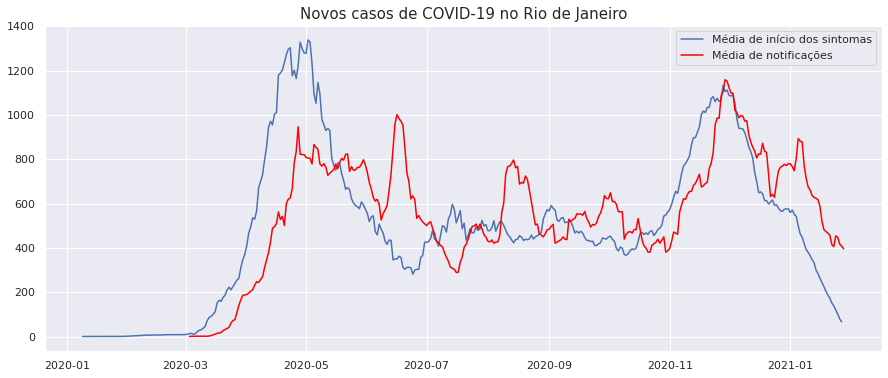

In [10]:
symptoms_start = covid_data.dt_inicio_sintomas.value_counts().sort_index()
sevendays_mean_symp = symptoms_start.rolling(window=7, center=True).mean()

fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(x = sevendays_mean_symp.index, 
             y = sevendays_mean_symp.values, 
             label = 'Média de início dos sintomas',
             ax = ax, 
            )
sns.lineplot(x = sevendays_mean.index, 
             y = sevendays_mean.values, 
             color = 'red',
             label = 'Média de notificações',
             ax = ax, 
            )
ax.set_title('Novos casos de COVID-19 no Rio de Janeiro', fontsize = 15)
fig.savefig('../images/comparing-symptoms-notifications.png', bbox_inches='tight', dpi = 400)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


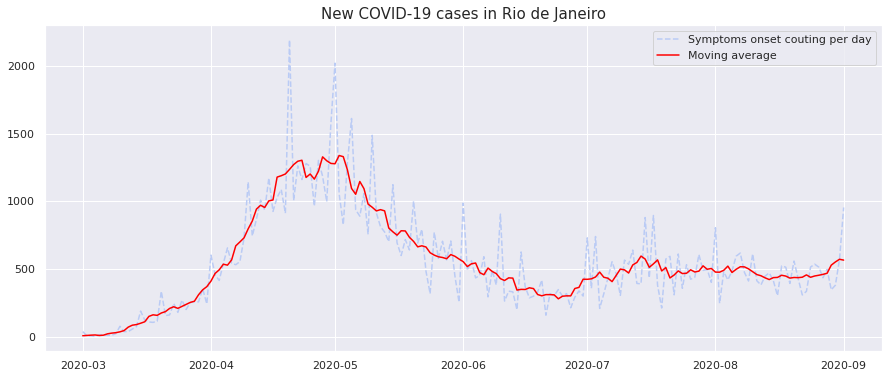

In [33]:
notified_cases = covid_data.dt_notific.value_counts().sort_index()
sevendays_mean = notified_cases.rolling(window=7, center=True).mean()

symptoms_start = covid_data.dt_inicio_sintomas.value_counts().sort_index()
sevendays_mean_symp = symptoms_start.rolling(window=7, center=True).mean()

fig, ax = plt.subplots(figsize = (15,6))

sns.lineplot(x = symptoms_start.loc['2020-03-01':'2020-09-01'].index, 
             y = symptoms_start.loc['2020-03-01':'2020-09-01'].values, 
             linestyle = '--',
             ax = ax, 
             color = "#BACBF5",
             label = 'Symptoms onset couting per day'
            )
sns.lineplot(x = sevendays_mean_symp.loc['2020-03-01':'2020-09-01'].index, 
             y = sevendays_mean_symp.loc['2020-03-01':'2020-09-01'].values, 
             label = 'Moving average',
             color = 'red',
             ax = ax, 
            )

ax.set_title('New COVID-19 cases in Rio de Janeiro', fontsize = 15)

fig.savefig('../images/new-symptoms-onset-rio.eps', bbox_inches='tight')
plt.show()

O primeiro pico do início dos sintomas não é repercutido na média de notificações (apesar de sabermos que a integral em todo o percurso é a mesma). Isso mostra que realmente se houver um surto, existe uma distribuição de quando as pessaos começam a sentir os sintomas. Existe um pico em agosto da média de notificações, mas esse pico não é antecipado por um de sintomas, o que é uma característica interessante. A curva de sintomas tem uma aparente constância maior. 

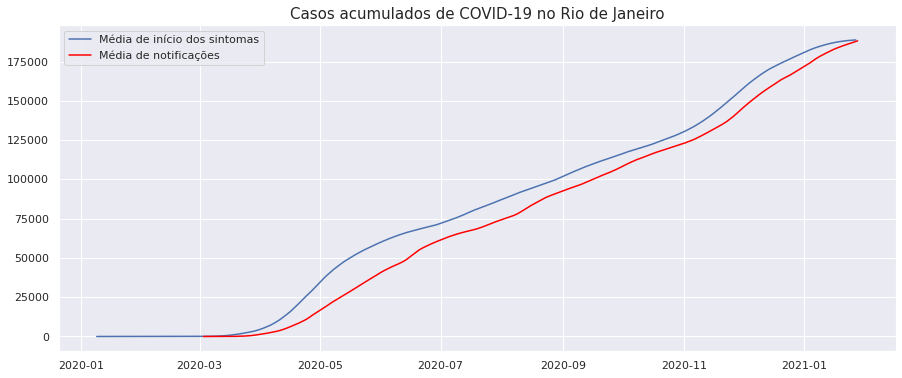

In [11]:
fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(x = sevendays_mean_symp.cumsum().index, 
             y = sevendays_mean_symp.cumsum().values, 
             label = 'Média de início dos sintomas',
             ax = ax, 
            )
sns.lineplot(x = sevendays_mean.cumsum().index, 
             y = sevendays_mean.cumsum().values, 
             color = 'red',
             label = 'Média de notificações',
             ax = ax, 
            )
ax.set_title('Casos acumulados de COVID-19 no Rio de Janeiro', fontsize = 15)
plt.show()

Em relação à integral das curvas, observamos que como esperado, a data de início de sintomas sempre é maior ou igual e, em particular, igual no último ponto. 

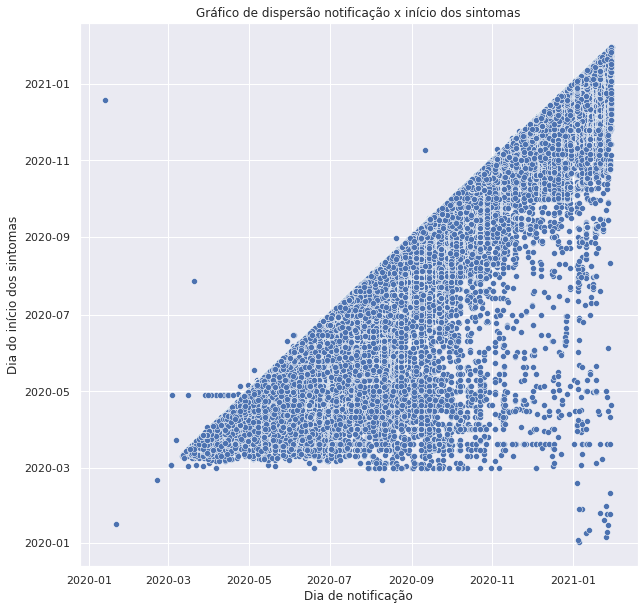

In [12]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = covid_data.dt_notific, y = covid_data.dt_inicio_sintomas)
plt.xlabel('Dia de notificação')
plt.title('Gráfico de dispersão notificação x início dos sintomas')
plt.ylabel('Dia do início dos sintomas')
plt.show()

O gráfico acima nos mostra particularidades muito importantes. Primeiro que a grande maioria dos dados está abaixo da linha $x=y,$ o que indica que a maioria dos casos foi notificado após sentir os primeiros sintomas. Os dados que estão acima dessa linha são certamente erros de digitação ou algumas pessoas que são identificadas pelo sistema ainda sem sintomas (o que parece ser raro). Em particular, vários dias de notificação diferentes marcaram o mesmo início de sintomas em maio de 2020, um erro que aparentemente não tem um motivo lógico. Outro erro bem comum foi a marcação do início dos sintomas no início de 2020, mas com notificação um anos após, o que parece um erro de digitação do ano. 

## Análise do tempo entre o início dos sintomas e notificação

Vamos verificar o histograma da quantidade de dias entre o início dos sintomas e a data de notificação. 

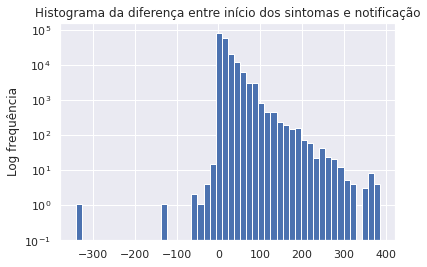

In [13]:
time_notific = (covid_data.dt_notific - covid_data.dt_inicio_sintomas)
time_notific = time_notific.dropna().apply(lambda x: x.days)

fig, ax = plt.subplots()
time_notific.plot.hist(ax=ax, bins=50, bottom=0.1)
ax.set_yscale('log')
ax.set_title('Histograma da diferença entre início dos sintomas e notificação')
ax.set_ylabel('Log frequência')
fig.savefig('../images/histogram-comparion.png', bbox_inches='tight', dpi = 400)
plt.show()

Observamos que quase 20% das pessoas informaram que o início dos sintomas foi há mais de 30 dias. 

In [14]:
sum(time_notific >= 30)/time_notific.shape[0]

0.1934255743885456

Vamos verificar o início dos sintomas que estão faltando. Para isso, vamos comparar esses dados faltantes com as outras colunas e tentar ver se existe algum padrão que pode ser extraído. 

In [15]:
nan_symtoms = covid_data[covid_data.dt_inicio_sintomas.isnull()]
bairro_counts = nan_symtoms.bairro_resid_estadia.value_counts()
bairro_counts/ covid_data.bairro_resid_estadia.value_counts()[bairro_counts.index]

ROCINHA                     0.052980
GAVEA                       0.032210
SAO CONRADO                 0.005579
JACAREPAGUA                 0.000453
INDEFINIDO                  0.000258
FORA DO MUNICIPIO           0.000344
RECREIO DOS BANDEIRANTES    0.000221
IPANEMA                     0.000434
CENTRO                      0.000340
Name: bairro_resid_estadia, dtype: float64

Nessa tabela verificamos a proporção de pacientes que não tiveram seu início dos sintomas notificado por bairro. Nesse caso, os bairros Rocinha e Gávea despontam com uma proporção muito maior, o que indica que ser da Rocinha pode aumentar a chance de não ser informado as suas informações. Os bairros que não aparecem nessa tabela não tiveram valores faltantes nesse campo. Essa grande diferença não é observada na faixa etária, nem no sexo. 

In [16]:
age = nan_symtoms.faixa_etaria.value_counts()
age/ covid_data.faixa_etaria.value_counts()[age.index]

De 50 a 59    0.001184
De 40 a 49    0.000605
De 30 a 39    0.000399
De 60 a 69    0.000595
De 20 a 29    0.000390
De 70 a 79    0.000477
De 10 a 19    0.000982
De 90 a 99    0.000375
Name: faixa_etaria, dtype: float64

In [17]:
sexo = nan_symtoms.sexo.value_counts()
sexo/ covid_data.sexo.value_counts()[sexo.index]

F    0.000741
M    0.000415
Name: sexo, dtype: float64

## Evolução dos casos

Agora vamos verificar as evoluções, que mostram o que aconteceu com o paciente confirmado. 

In [18]:
covid_data.evolucao.unique()

array(['OBITO', 'ATIVO', 'RECUPERADO'], dtype=object)

In [26]:
(covid_data[(covid_data.dt_evolucao.isnull())&(covid_data.dt_notific < '2020-07-31')]
 .evolucao.value_counts()/covid_data[(covid_data.dt_notific < '2020-07-31')].shape[0])

ATIVO         0.033424
RECUPERADO    0.004329
OBITO         0.000014
Name: evolucao, dtype: float64

Acima podemos ver que daqueles que não tiveram a data de evolução informada, a grande maioria é porque não evoluiu ainda e, portanto, é caso ativo. Alguns recuperados e óbitos não tiveram sua data de evolução confirmada. Sabemos que a data de evolução pode ter um atraso e esse atraso pode ser maior ainda para casos recuperados. Vamos verificar, após a data de notificação, quantos dias até o óbito.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


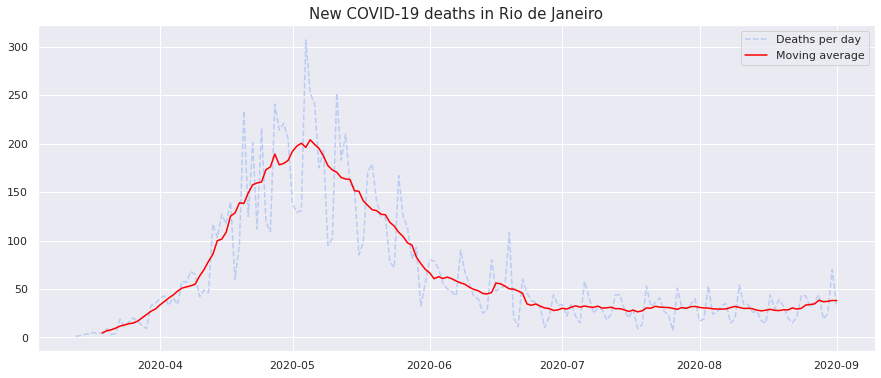

In [34]:
deaths = covid_data[covid_data.evolucao == 'OBITO'].dt_notific.value_counts().sort_index()
sevendays_mean_deaths = deaths.rolling(window=7, center=True).mean()

fig, ax = plt.subplots(figsize = (15,6))

sns.lineplot(x = deaths.loc['2020-03-01':'2020-09-01'].index, 
             y = deaths.loc['2020-03-01':'2020-09-01'].values, 
             linestyle = '--',
             ax = ax, 
             color = "#BACBF5",
             label = 'Deaths per day'
            )
sns.lineplot(x = sevendays_mean_deaths.loc['2020-03-01':'2020-09-01'].index, 
             y = sevendays_mean_deaths.loc['2020-03-01':'2020-09-01'].values, 
             label = 'Moving average',
             color = 'red',
             ax = ax, 
            )

ax.set_title('New COVID-19 deaths in Rio de Janeiro', fontsize = 15)

fig.savefig('../images/new-deaths-rio.eps', bbox_inches='tight')
plt.show()

No próximo gráfico podemos observar que grande parte dos dos dados tem a data de evolução anterior a própria notificação. Isso se deve ao formato irregular ao registro de notificação de casos. Em particular, podemos ver como isso se repercute quando o caso é recuperado e quando o caso é de morte. 

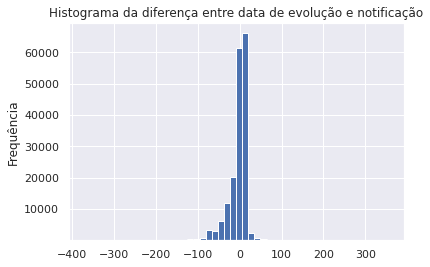

In [22]:
time_evolution = (covid_data.dt_evolucao - covid_data.dt_notific)
time_evolution = time_evolution.dropna().apply(lambda x: x.days)

fig, ax = plt.subplots()
time_evolution.plot.hist(ax=ax, bins=50, bottom=0.1)
ax.set_title('Histograma da diferença entre data de evolução e notificação')
ax.set_ylabel('Frequência')
plt.show()

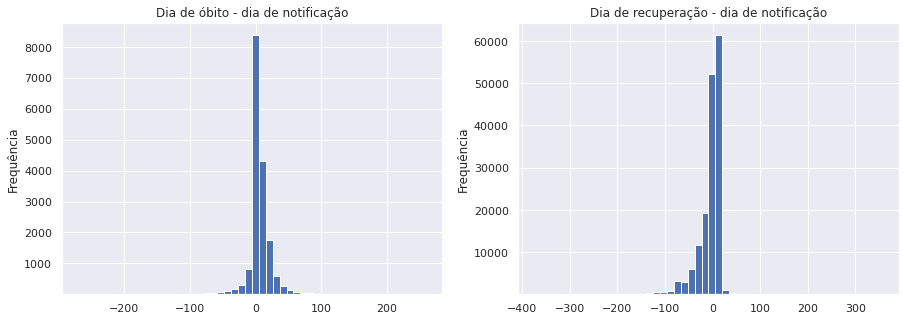

In [23]:
deaths = covid_data[covid_data.evolucao == 'OBITO']
recovered = covid_data[covid_data.evolucao == 'RECUPERADO']

time_death = (deaths.dt_evolucao - deaths.dt_notific)
time_death = time_death.dropna().apply(lambda x: x.days)

time_recovered = (recovered.dt_evolucao - recovered.dt_notific)
time_recovered = time_recovered.dropna().apply(lambda x: x.days)

fig, ax = plt.subplots(1,2, figsize = (15,5))

time_death.plot.hist(ax=ax[0], bins=50, bottom=0.1)
ax[0].set_title('Dia de óbito - dia de notificação')
ax[0].set_ylabel('Frequência')

time_recovered.plot.hist(ax=ax[1], bins=50, bottom=0.1)
ax[1].set_title('Dia de recuperação - dia de notificação')
ax[1].set_ylabel('Frequência')

plt.show()

O fato de as pessoas se recuperarem antes mesmo da notificação corrobora a hipótese de que a testagem muitas vezes é confirmada dias depois, o que reintera o problema das testagens. 

## Dados para estimação dos parâmetros 

Segundo [Painel Coronavírus COVID-19](http://painel.saude.rj.gov.br/monitoramento/covid19.html), para os casos confirmados, consideramos preferencialmente a coluna do início dos sintomas. Caso esses dados não estejam presentes, sugerimos a seguinte imputação de valores: a partir dos dados presentes, podemos fazer uma estimativa da distribuição da diferença de dias entre início dos sintomas e notificação - a distribuição que vimos no gráfico na escala log anteriormente. Então pegamos um dia aleatório segundo essa distribuição. Faremos o mesmo para os dois óbitos que não tem informação da data. Assim, vamos ler os valores de casos confirmados, e desses, o que levaram a óbito. 

In [24]:
data = covid_data[['dt_notific', 'dt_inicio_sintomas', 'evolucao', 'dt_evolucao']]
p = time_notific.value_counts() / time_notific.shape[0]

ro = np.random.RandomState(123456)
diff = pd.to_timedelta(np.random.choice(p.index, p = p.values, size = nan_symtoms.shape[0]), unit = 'day')

for i, j in enumerate(nan_symtoms.index): 
    data.loc[j, 'dt_inicio_sintomas'] = data.loc[j, 'dt_notific'] - diff[i]


p = time_death.value_counts() / time_death.shape[0]

nan_deaths = covid_data[(covid_data.dt_evolucao.isnull()) & (covid_data.evolucao == 'OBITO')]
diff = pd.to_timedelta(np.random.choice(p.index, p = p.values, size = nan_deaths.shape[0]), unit = 'day')

for i, j in enumerate(nan_deaths.index): 
    data.loc[j, 'dt_evolucao'] = data.loc[j, 'dt_notific'] + diff[i]

/home/lucasmoschen/anaconda3/envs/covid/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Agora vamos separa os dados que usaremos.

In [25]:
df1 = data.dt_inicio_sintomas.value_counts().sort_index()
df2 = data[data.evolucao == 'OBITO'].dt_evolucao.value_counts().sort_index()
frame = {'confirmed': df1, 'deaths': df2}
df = pd.DataFrame(frame)

Alguns dias terão mortes NaN. Isso ocorre porque não foram registradas mortes, então colocamos o valor 0. 

In [26]:
df.fillna(0, inplace=True)

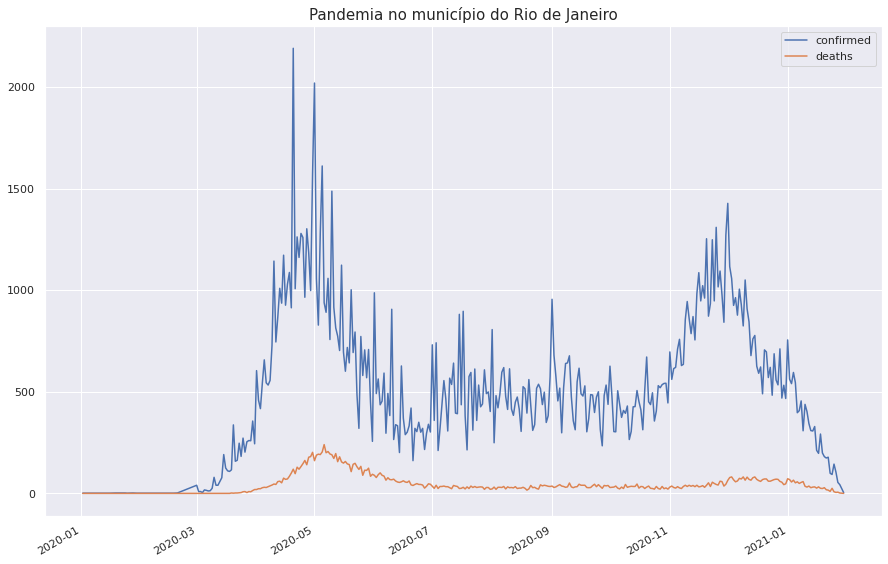

In [27]:
fig, ax = plt.subplots(figsize = (15,10))
df.plot(ax = ax)
ax.set_title('Pandemia no município do Rio de Janeiro', fontsize = 15)
plt.show()

## Médias móveis e sazonalidade

Constatamos ao longo do surto que existe uma sazonalidade semanal nos casos
confirmados e de morte, dado que nos fins de semana há um desvio negativo,
enquanto na terça um positivo. Essa variação semanal prejudica o modelo, dado
que ele não possui ajuste para a sazonalidade da contagem. Por esse motivo, a
aplicação de um suavizador se faz necessário. Portanto, nosso dado será da forma 
$$
\hat{X}_t = \frac{1}{2k + 1}\sum_{s=-k}^k X_s
$$

Vamos fazer $2k + 1 = 7$. Outra observação é que o modelo considera os dados normalizados em função do tamanho da população. Vamos assumir que o tamanho da população do Rio de Janeiro é de 6.7 milhões. 

In [28]:
population = 6.7e6
df_trans = (df/population).rolling(window = 7, center = True).mean()

## Salvando dados 

Vamos desconsiderar dados anteriores a março, em vista que o primeiro caso só foi reportado em [6 de março](https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/07/secretaria-de-estado-de-saude-confirma-o-segundo-caso-do-novo-coronavirus-no-rio-de-janeiro.ghtml), com início dos sintomas no dia 4 de março. Em particular o dia primeiro de março será desconsiderado devido ao alto número de casos aparentemente não relacionados com o início da pandemia na cidade. Também calculamos as curvas acumuladas. 

In [29]:
df1 = df_trans[(df_trans.index.year == 2021) | (df_trans.index.month > 2)].iloc[1:]
df1 = df1.cumsum()
df1.to_csv('../data/covid_data_organized.csv')